# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [163]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc

# Fixed random state
rs = 15122021

# Options for pandas
pd.set_option('max_colwidth', 200)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 100)

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [85]:
df = pd.read_csv('data.adult.csv')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [87]:
df.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


In [88]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.
    :param df: Набор данных для вычисления статистики.
    :return: Датафрейм со статистикой распределения пропусков.
    """
    na = df.isnull().sum()
    result = pd.DataFrame(data={"Кол-во уникальных": df.nunique(),
                                "Кол-во заполненных": df.shape[0] - na,
                                "Кол-во пропусков": na,
                                "Доля пропусков, %": 100 * na / df.shape[0],
                                "Тип": df.dtypes})
    print(f"Total NA-values = {na.sum()}")
    return result

In [89]:
check_missings(df)

Total NA-values = 0


,Кол-во уникальных,Кол-во заполненных,Кол-во пропусков,"Доля пропусков, %",Тип
age,73,16280,0,0.0,int64
workclass,9,16280,0,0.0,object
fnlwgt,12773,16280,0,0.0,int64
education,16,16280,0,0.0,object
education-num,16,16280,0,0.0,int64
marital-status,7,16280,0,0.0,object
occupation,15,16280,0,0.0,object
relationship,6,16280,0,0.0,object
race,5,16280,0,0.0,object
sex,2,16280,0,0.0,object


При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? В каком диапазоне лежат исследуемые признаки?

In [90]:
def plot_distributions(dataset):
    """Plot histograms for numerical columns."""
    dataset.select_dtypes(include=[np.number]).hist(figsize=(10,10))

def plot_boxplots(dataset):
    """Plot boxplots for numerical columns to identify outliers."""
    for column in dataset.select_dtypes(include=[np.number]).columns:
        plt.figure(figsize=(5, 5))
        sns.boxplot(y=dataset[column])
        plt.title(f'Boxplot of {column}')

def plot_countplots(dataset):
    """Plot countplots for categorical columns."""
    for column in dataset.select_dtypes(include=[object]).columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=dataset, x=column)
        plt.title(f'Countplot of {column}')
        plt.xticks(rotation=45)

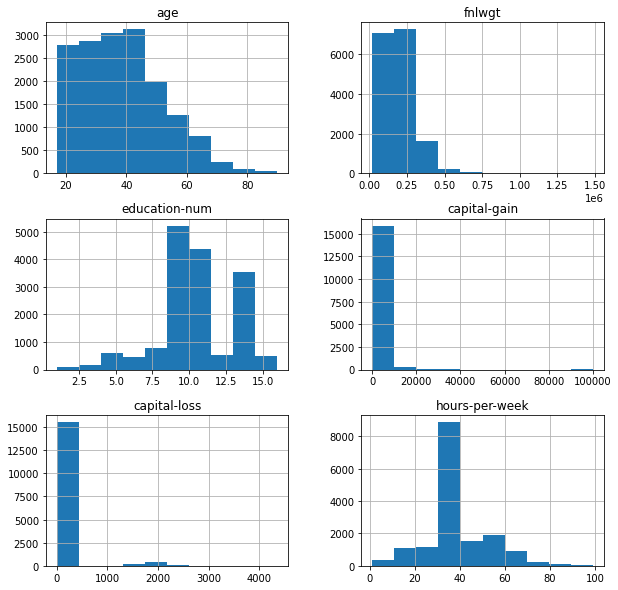

In [91]:
# Plot distributions
plot_distributions(df)

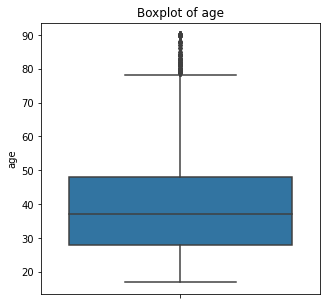

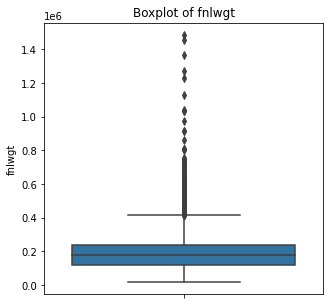

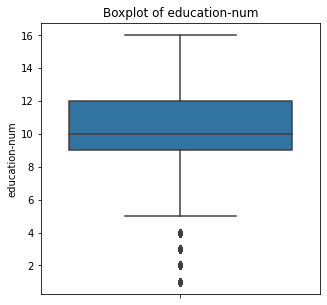

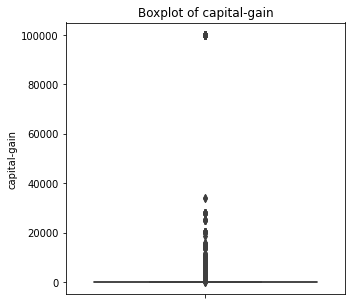

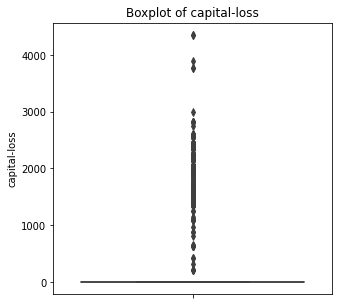

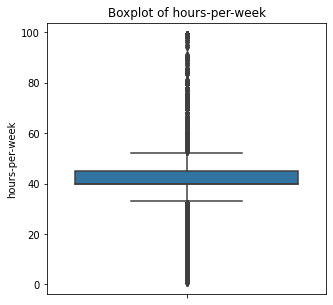

In [92]:
# Plot boxplots
plot_boxplots(df)

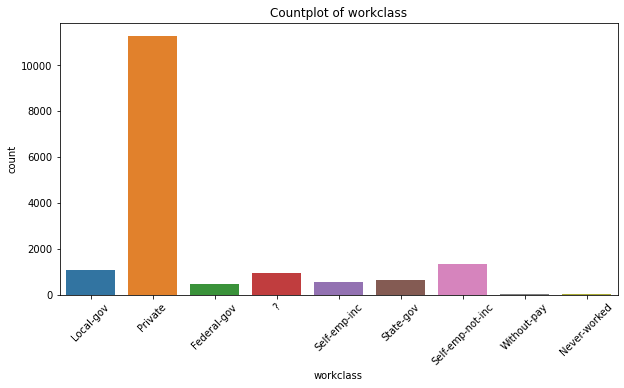

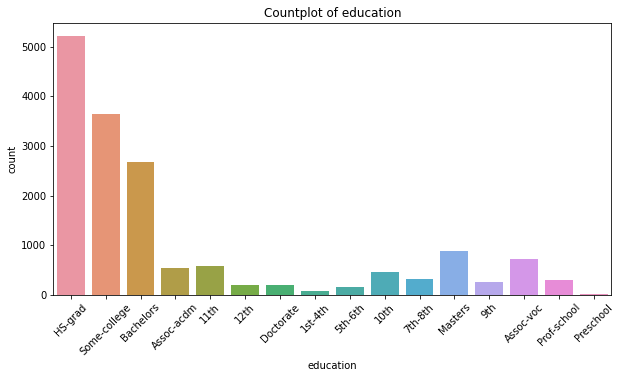

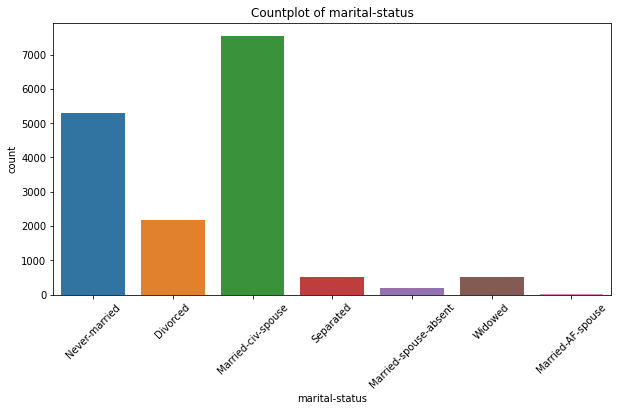

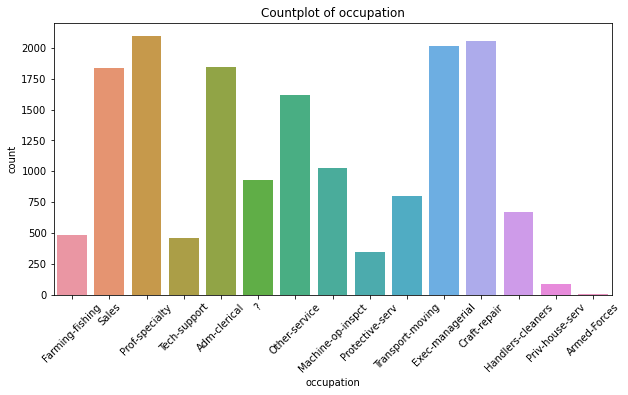

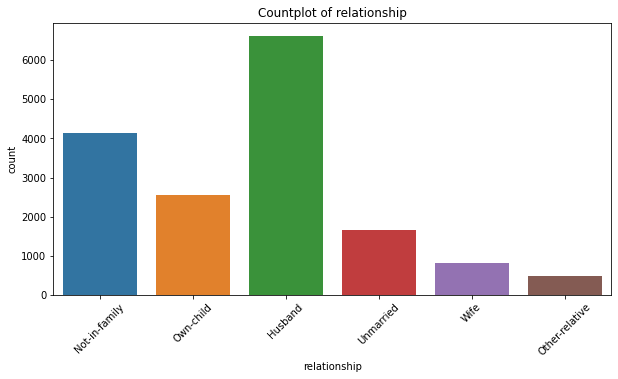

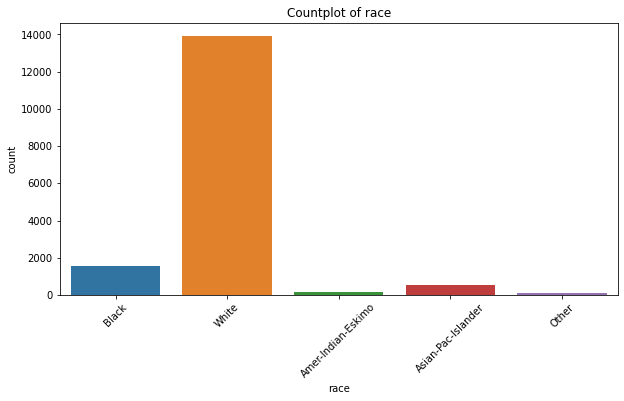

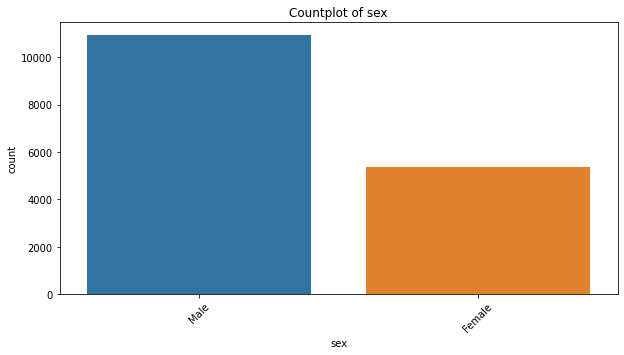

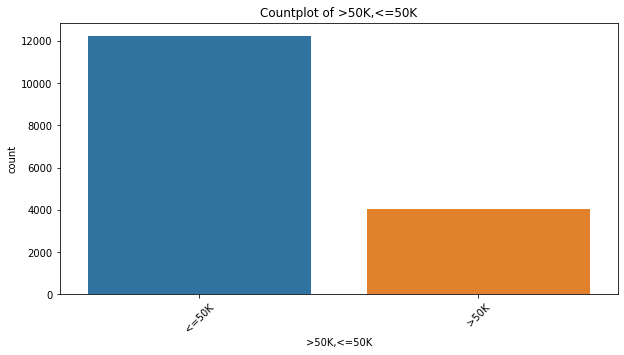

In [93]:
# Plot countplots
plot_countplots(df)

## Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

In [94]:
def preprocess_data(dataset, target):
    """Handle missing values, encode categorical variables, and normalize numerical columns."""
    # Handle missing values
    imputer = SimpleImputer(strategy='most_frequent')
    dataset = pd.DataFrame(imputer.fit_transform(dataset), columns = dataset.columns)
    
    # Encoding categorical columns and target
    le = LabelEncoder()
    for column in dataset.select_dtypes(include=[object]).columns:
        dataset[column] = le.fit_transform(dataset[column])

    # Convert target variable to binary format
    dataset[target] = le.fit_transform(dataset[target])
    
    # Normalize numerical columns
    scaler = StandardScaler()
    for column in dataset.select_dtypes(include=[np.number]).columns:
        if column != target: # Do not normalize the target
            dataset[column] = scaler.fit_transform(dataset[column].values.reshape(-1, 1))
    
    return dataset

In [95]:
# Preprocess the data
dataset = preprocess_data(df, '>50K,<=50K')

In [96]:
def split_data(dataset, target, test_size=0.4):
    """Split the data into train and test sets."""
    X = dataset.drop(target, axis=1)
    y = dataset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [97]:
# Split the data
X_train, X_test, y_train, y_test = split_data(dataset, '>50K,<=50K')

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Для начала обучим  выберем один гиперпараметр, который будем оптимизировать, — глубина дерева (*max_depth*).
 
Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

In [98]:
def train_models(X_train, y_train):
    """Train different models and return them."""
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=rs),
        'Random Forest': RandomForestClassifier(random_state=rs),
        'CatBoost': CatBoostClassifier(random_state=rs, verbose=False),
        'XGBoost': XGBClassifier(random_state=rs),
        'LightGBM': LGBMClassifier(random_state=rs),
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        print(f'{name} has been trained successfully!')

    return models

In [99]:
# Train the models
models = train_models(X_train, y_train)

Decision Tree has been trained successfully!
Random Forest has been trained successfully!
CatBoost has been trained successfully!
XGBoost has been trained successfully!
LightGBM has been trained successfully!


Далее произведем подбор других гиперпараметров алгоритмов. Начнет со случайного леса. Для начала подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите количество деревьев, начиная с которого качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящих из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте подобранное количество деревьев.

In [100]:
def tune_hyperparameters(models, X_train, y_train):
    """Tune hyperparameters using RandomizedSearchCV and return the best models."""
    param_distributions = {
        'Decision Tree': {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5]
        },
        'CatBoost': {
            'learning_rate': [0.01, 0.05, 0.1],
            'depth': [5, 7, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7, 10],
            'min_child_weight': [1, 3, 5]
        },
        'LightGBM': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [-1, 5, 10, 15],
            'num_leaves': [31, 50, 100, 200]
        }
    }

    for name, model in models.items():
        rs = RandomizedSearchCV(model, param_distributions[name], cv=3, n_jobs=-1, verbose=False)
        rs.fit(X_train, y_train)
        models[name] = rs.best_estimator_
        print(f'{name} hyperparameters have been tuned to: {rs.best_params_}.')

    return models

In [101]:
# Tune hyperparameters
models = tune_hyperparameters(models, X_train, y_train)

Decision Tree hyperparameters have been tuned to: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5}.
Random Forest hyperparameters have been tuned to: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15}.
CatBoost hyperparameters have been tuned to: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'depth': 7}.
XGBoost hyperparameters have been tuned to: {'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05}.
LightGBM hyperparameters have been tuned to: {'num_leaves': 31, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05}.


## Тестирование всех модели

Протестируйте последние построенные модели (наилучшее решающее дерево и наилучший случайный лес) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [150]:
def evaluate_models(models, X_test, y_test):
    """Evaluate models on the test set using ROC-AUC and F1 score."""
    results = []
    for name, model in models.items():
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Compute metrics
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        
        results.append({'Model': name, 'ROC-AUC': roc_auc, 'F1_Score': f1})
        results_df = pd.DataFrame(results)
        
        print(f'{name}: ROC-AUC = {roc_auc:.3f}, F1_Score = {f1:.3f}')
    return results_df

In [151]:
# Evaluate the models
results_df = evaluate_models(models, X_test, y_test)

Decision Tree: ROC-AUC = 0.871, F1_Score = 0.632
Random Forest: ROC-AUC = 0.913, F1_Score = 0.668
CatBoost: ROC-AUC = 0.922, F1_Score = 0.687
XGBoost: ROC-AUC = 0.921, F1_Score = 0.703
LightGBM: ROC-AUC = 0.925, F1_Score = 0.702


In [152]:
results_df

,Model,ROC-AUC,F1_Score
0,Decision Tree,0.871246,0.632387
1,Random Forest,0.913268,0.668353
2,CatBoost,0.922248,0.687060
3,XGBoost,0.920740,0.702666
4,LightGBM,0.924764,0.702142


## Сравнение результатов

Сравните результаты алгоритмво. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [154]:
def visualize_results(results):
    """Plot ROC-AUC and F1 scores for each model."""
    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df, x='Model', y='ROC-AUC')
    plt.title('ROC-AUC Scores of Models')
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df, x='Model', y='F1_Score')
    plt.title('F1 Scores of Models')

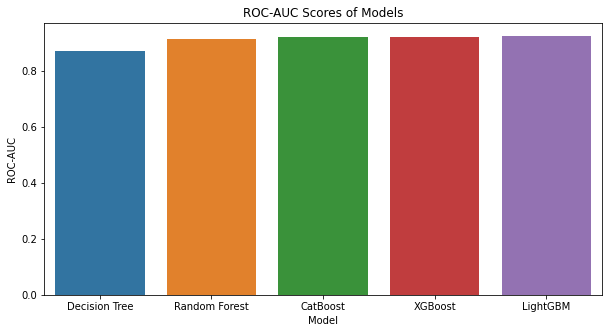

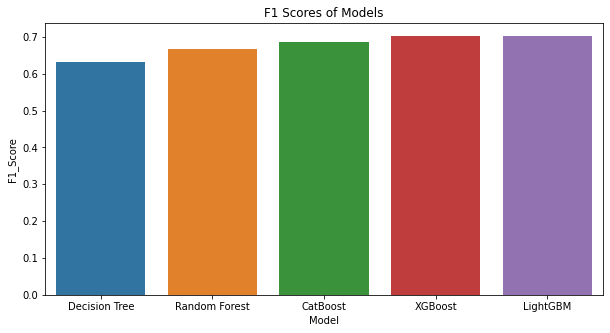

In [155]:
# Visualize the results
visualize_results(results)

In [164]:
def plot_roc_curves(models, X_test, y_test):
    """Plot ROC curves for each model and compare them to a baseline."""
    # Create a baseline model
    dummy = DummyClassifier(strategy='stratified', random_state=42)
    dummy.fit(X_test, y_test)
    y_dummy_pred = dummy.predict_proba(X_test)[:, 1]
    dummy_fpr, dummy_tpr, th = roc_curve(y_test, y_dummy_pred)
    auc_roc = roc_auc_score(y_test, y_dummy_pred)
    dummy_roc_auc = auc(dummy_fpr, dummy_tpr)

    plt.figure(figsize=(10, 10))
    plt.plot(dummy_fpr, dummy_tpr, linestyle='--', label='Baseline (area = %0.2f)' % dummy_roc_auc)

    # Plot ROC curves for each model
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, th = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (area = %0.2f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

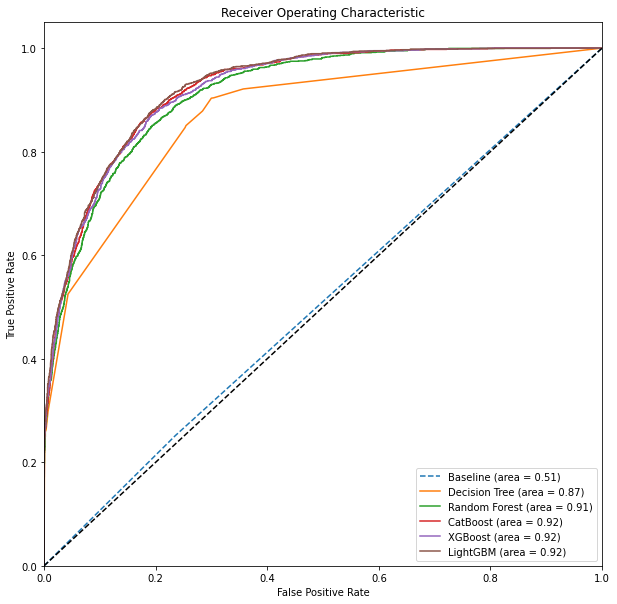

In [165]:
# Plot ROC curves
plot_roc_curves(models, X_test, y_test)

# ВЫВОД

Модели бустинга показали себя примерно одинаково хорошо. <br>
Лучшая модель - `LightGBM`,  с показателями: <br>
`ROC-AUC: 0.924764`, <br>
`F1: 0.702142`